CRP dynamically rebalances Collateral to ensure the ayToken minted (i.e. the loan) remains solvent, especially in an adverse market environment (i.e. the value of the loan does not exceed the value of Collateral). This dynamic rebalancing, together with a careful choice of the key parameters (including LTV and volatility assumption) allows ALEX to eliminate the liquidation needs. Any residual gap risk (which CRP cannot address entirely) is addressed through maintaining a strong reserve fund.
When a Borrower mints ayToken by providing appropriate Collateral, the Collateral is converted into a basket of Collateral and Token, with the weights determined by CRP. CRP determines the weights based on the prevailing LTV and uses the following formula:

$$ w_{Token} = N(d_1) $$
$$ w_{Collateral} = (1 - w_{Token}) $$ 

\begin{equation}
d_1 = \frac{1}{\sigma \sqrt{(t)}} [ln (\frac{LTV_t}{LTV_0}) + t \cdot (APY_{Token} - APY_{Collateral} + \frac{\sigma^2}{2})] 
\label{eq:CRP} \tag{1} 
\end{equation}


We conduct a number of simulations to help understand the loan values and default risk (i.e LTV >1) in various market environments.  For simplicity, fees and APY are not considered in this round of simulation. We set initial weights to be 50/50 and loan life time = 91 days.  

### Key parameters
In this simualtion, we consider the following key parameters: 

    (1) Initial LTV: range from 0.7 to 0.95
    (2) Black scholes volatility: $\sigma$ range from 0.1 - 0.5  

### Market enviroment     
To simulate the different markets, we assume the token price move at a linear annual growth rate (r) plus random walk with volatility $\eta$.  We allow the growth rate to vary from -2 to 2 (corresponding to 25% or 200% of the initial price). The token price's drop won't pressure the LTV(t), but will affect the total pool value. 
   
    (3) Growth rate: $r$ range from $[-2, 2]$ 
    (4) Growth rate volatility: $\eta$ range from 0.1 - 0.5


### Measures

For each setup [1-4], based on the token price change, we rebalance Collateral and token according to $\eqref{eq:CRP}$.  The following metrics are measures during the whole loan life term: 


a. LTV at time t 
b. Token price at t
c. Collateral weight at t
d. Impermanent loss of the pool LP.  
    $$IL = \frac{PoolValue_{usd}}{HoldValue_{usd}}$$


For example the Token price moves up with low volatility.  
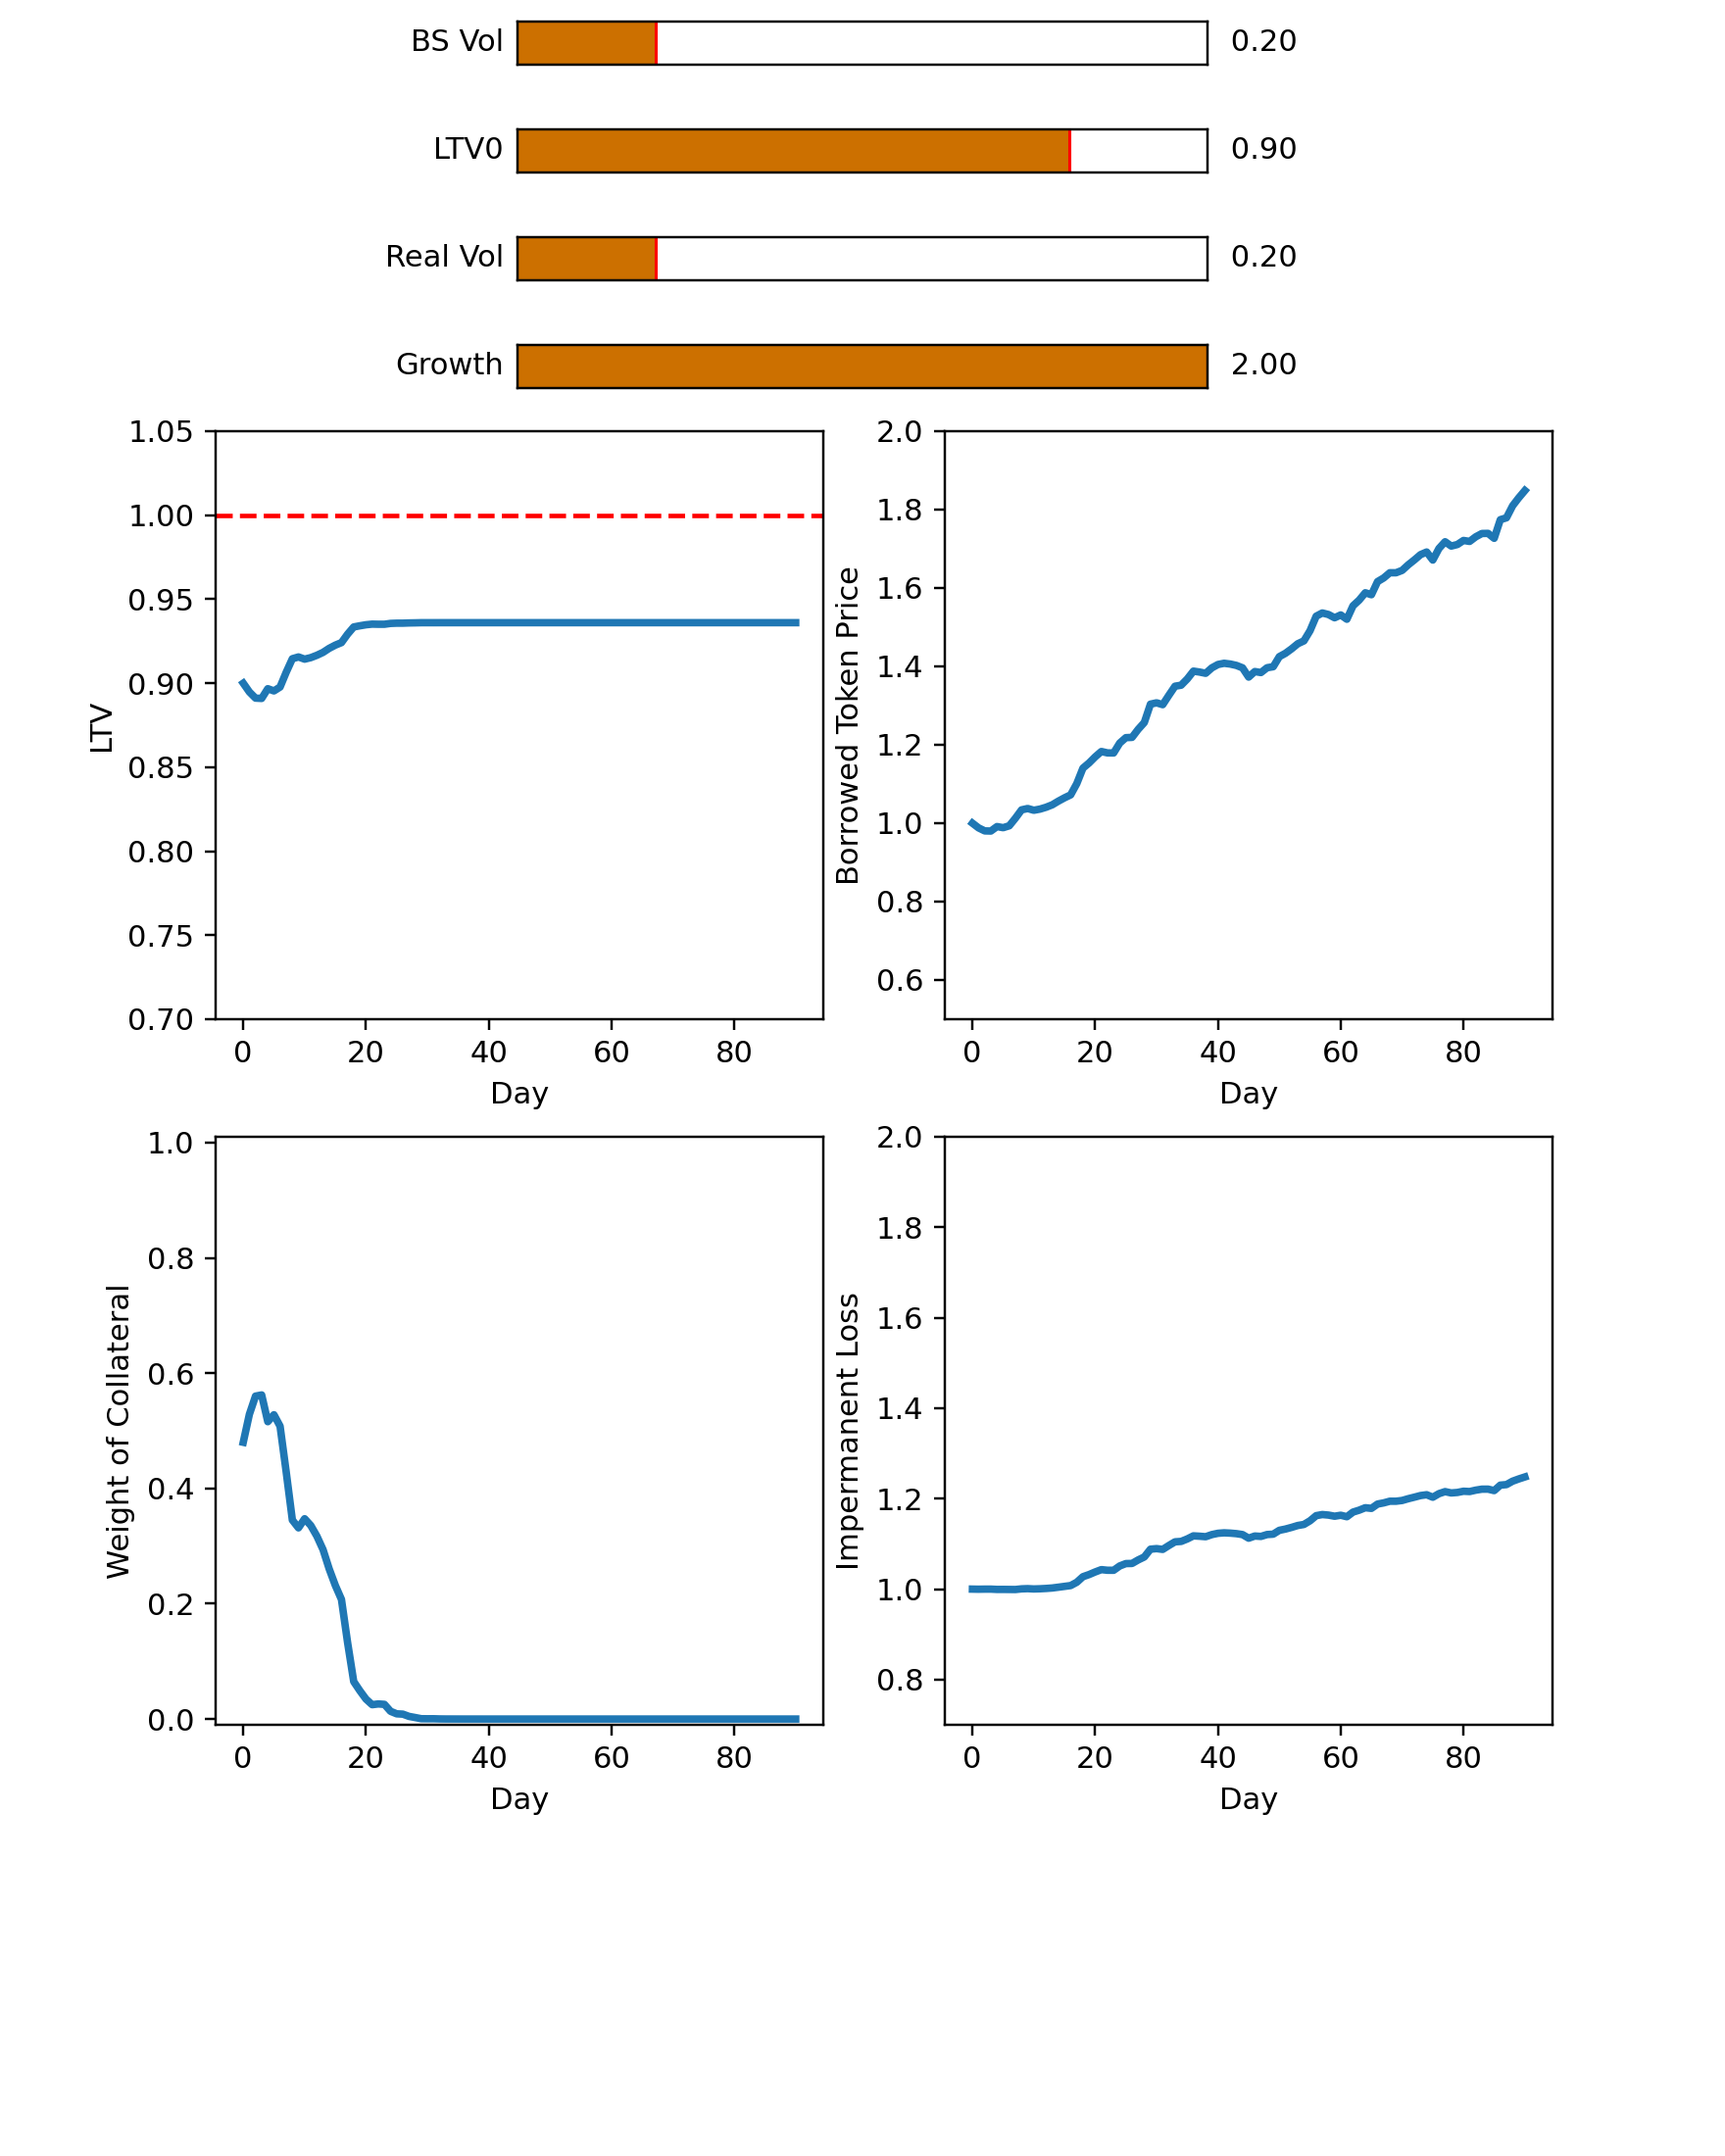


#### Simulation 2:
For each selected combination (1) to (4), run the process 100 times and count the number of events that LVT(t) > 1 at any time point.  Report the frequency by LTV0 and growth rate for a given volatility setup.     
    
For example this is the simulation results when growth rate volatility is high, and black sholes volatility is under-estimated. 
The size of button indicate the chance of default when LVT is hight, even the growth rate is low.    

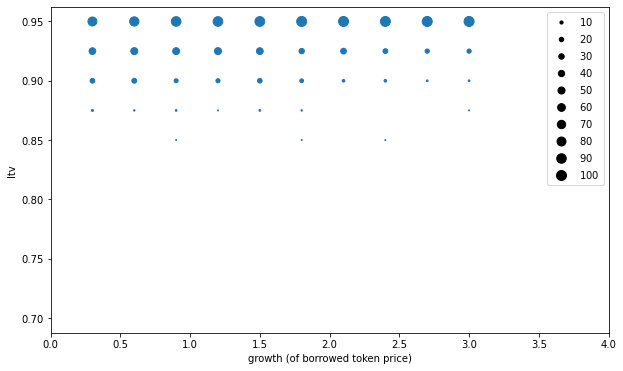


URLhttps://medium.com/balancer-protocol/80-20-balancer-pools-ad7fed816c8d
    

In [40]:
# plot of liquity 

import scipy 
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.widgets import Slider
import seaborn as sns
import numpy as np 
import random
import pandas as pd 
from ipywidgets import *
from scipy.stats import norm



In [41]:
def gen_data(t, BTC, Collateral, LTV0, bs_vol, Growth_rate, Real_vol): 
    for i in range(0, len(t)): 
        if i == 0: 
            btc_usd = BTC
            borrow_btc_usd = Collateral*LTV0 
            ltv = LTV0
            collateral_usd = Collateral
            w_btc = norm.cdf((np.log(btc_usd)-np.log(BTC)+ t[i]*(0.5*bs_vol**2))/bs_vol/np.sqrt(t[i]))
            btc_locked = collateral_usd/btc_usd* w_btc 
            usd_locked = collateral_usd*(1-w_btc)
            loss = 1
            out = np.array([t[i], btc_usd, borrow_btc_usd, ltv, btc_locked, usd_locked, collateral_usd, w_btc, loss])  
            out = out.reshape(1,9)
        else:
            ti = t[i-1]-t[i]
            rw = random.random()
            btc_usd_previous = btc_usd
            btc_usd = btc_usd_previous*np.exp(ti * (Growth_rate - 0.5*Real_vol**2) +  Real_vol *np.sqrt(ti)*norm.ppf(rw))
            borrow_btc_usd = borrow_btc_usd/btc_usd_previous*btc_usd 
            w_btc = norm.cdf((np.log(btc_usd)-np.log(BTC)+ t[i]*(0.5*bs_vol**2))/bs_vol/np.sqrt(t[i]))
            collateral_usd = btc_locked * btc_usd + usd_locked 
            ltv = borrow_btc_usd/collateral_usd 
            btc_locked = collateral_usd/btc_usd*w_btc 
            usd_locked = collateral_usd * (1-w_btc)
            holdvalue = Collateral #/2 +  Collateral/2/BTC*btc_usd
            loss = collateral_usd/holdvalue 
            _out = np.array([t[i], btc_usd, borrow_btc_usd, ltv, btc_locked, usd_locked, collateral_usd, w_btc, loss]) 

            out = np.append(out, _out.reshape(1,9), axis =0)  
    output = pd.DataFrame(data=out)
    output.columns = ['t', 'btc_usd', 'borrow_btc_usd', 'ltv', 'btc_locked', 'usd_locked', 'collateral_usd', 'w_btc', 'imper_loss']
    output['pool_value_ratio'] = output['collateral_usd']/Collateral
    return output 

In [42]:
# Simulation 1 
#set initial parameters 
Growth_rate = 2
Real_vol = 0.4
Collateral = 10000
LTV0 = 0.95 
bs_vol = 0.2
BTC = 50
t = np.linspace(91,1,91)/365


<IPython.core.display.Javascript object>


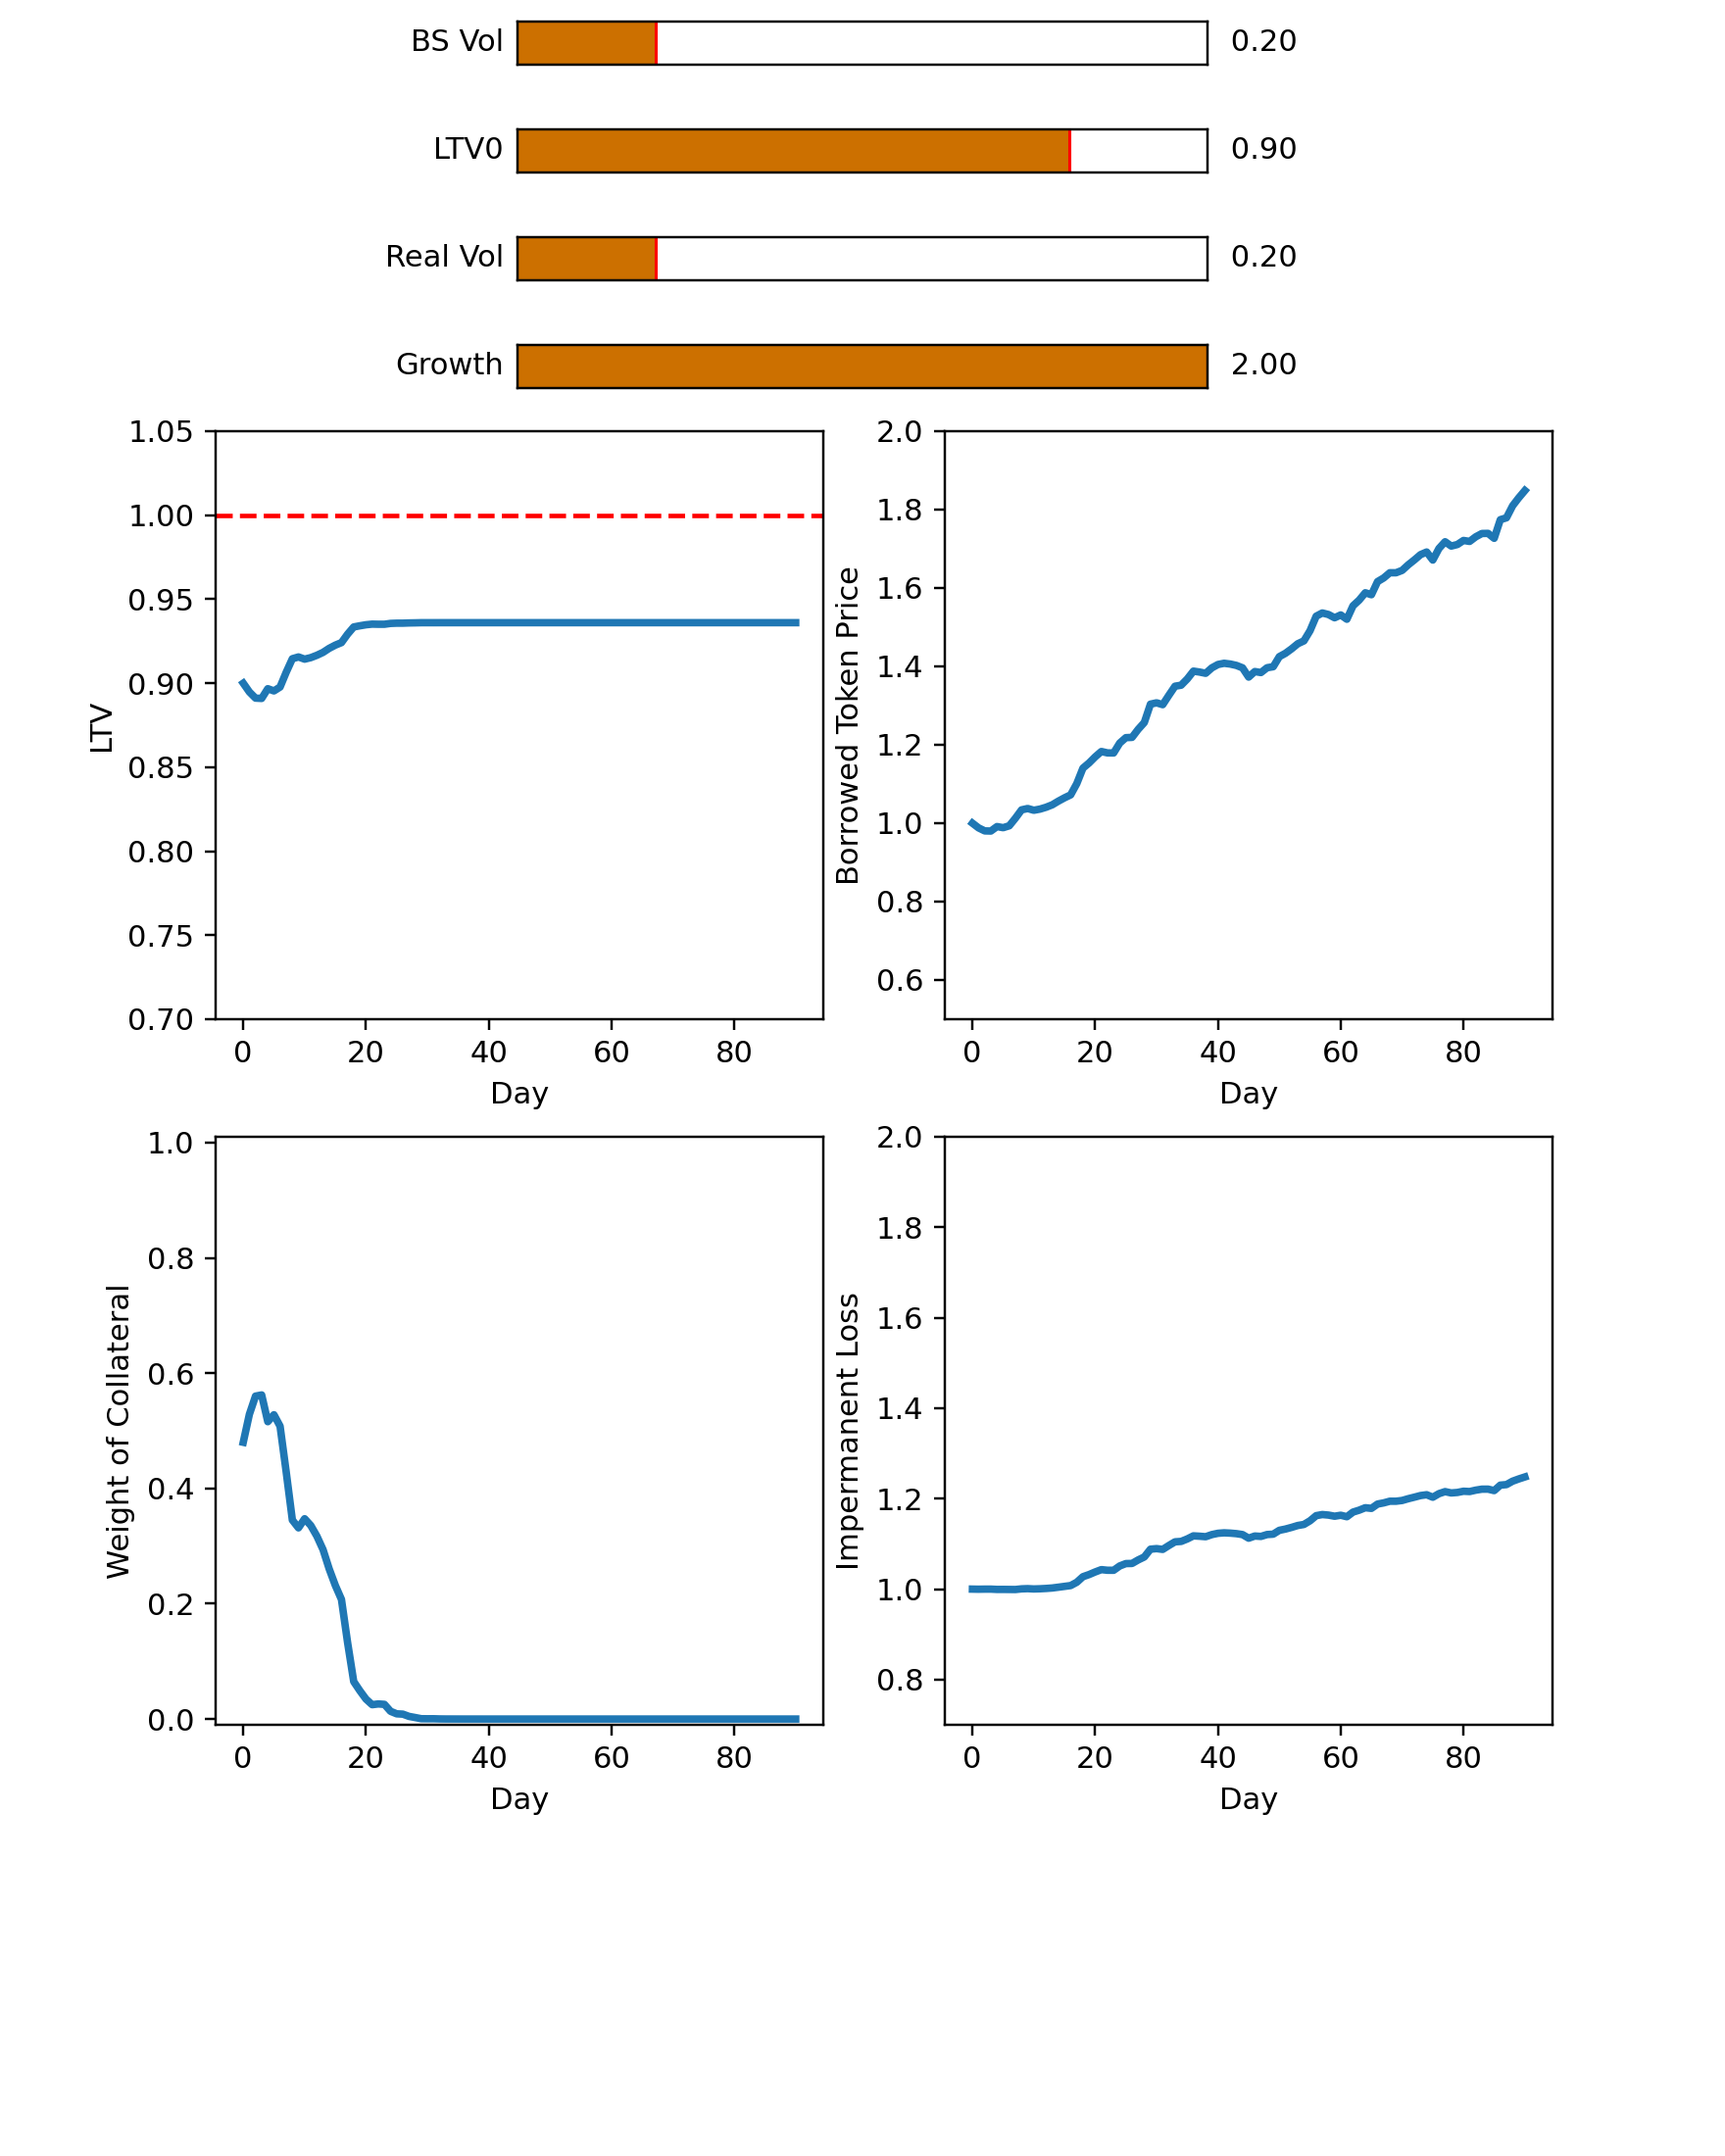

In [51]:
%matplotlib notebook

import matplotlib.pyplot as plt 
#fig = plt.figure(figsize=(6,6))
fig, axs = plt.subplots(2,2,figsize=(8,10))
# Create main axis
fig.subplots_adjust(bottom=0.2, top=0.80)
# Create axes for sliders
ax_growth = fig.add_axes([0.3, 0.82, 0.4, 0.02])
ax_growth.spines['top'].set_visible(True)
ax_growth.spines['right'].set_visible(True)

ax_real_vol = fig.add_axes([0.3, 0.87, 0.4, 0.02])
ax_real_vol.spines['top'].set_visible(True)
ax_real_vol.spines['right'].set_visible(True)

ax_ltv = fig.add_axes([0.3, 0.92, 0.4, 0.02])
ax_ltv.spines['top'].set_visible(True)
ax_ltv.spines['right'].set_visible(True)

ax_bs_vol = fig.add_axes([0.3, 0.97, 0.4, 0.02])
ax_bs_vol.spines['top'].set_visible(True)
ax_bs_vol.spines['right'].set_visible(True)


# Create sliders
s_real_vol= Slider(ax=ax_real_vol, label='Real Vol', valmin=0.1, valmax=1.0, valinit=0.2, valfmt=' %1.2f ', facecolor='#cc7000')
s_growth = Slider(ax=ax_growth, label='Growth', valmin=-2, valmax=2, valinit=2, valfmt=' %1.2f', facecolor='#cc7000')
s_bs_vol= Slider(ax=ax_bs_vol, label='BS Vol', valmin=0.1, valmax=1.0, valinit=0.2, valfmt=' %1.2f ', facecolor='#cc7000')
s_ltv = Slider(ax=ax_ltv, label='LTV0', valmin=0.7, valmax=0.95, valinit=0.9, valfmt=' %1.2f', facecolor='#cc7000')

# Plot default data
t =  np.linspace(91,1,91)/365
t
real_vol_0 = 0.2
growth_0 = 2
ltv0 = 0.9
bs_vol0 = 0.2 
_data = gen_data(t, BTC, Collateral, ltv0, bs_vol0, growth_0, real_vol_0)
x = _data.index.values
y1 = _data['ltv']
y2 = _data['btc_usd']/BTC
y3 = 1-_data['w_btc']
y4 = _data['imper_loss']
y5 = _data['w_btc']

f_d1, = axs[0,0].plot(x, y1, linewidth=2.5)
f_d2, = axs[0,1].plot(x, y2, linewidth=2.5)
f_d3, = axs[1,0].plot(x, y3, linewidth=2.5)
f_d4, = axs[1,1].plot(x, y4, linewidth=2.5)
f_d5, = axs[1,0].plot(x, y5, linewidth=2.5)
axs[0,0].set_ylim(0.7,1.05)
axs[0,0].axhline(y = 1, color = 'r', linestyle = '--')
axs[0,1].set_ylim(0.5,2)
axs[1,0].set_ylim(-0.01,1.01)
axs[1,1].set_ylim(0.7,2)
axs[0,0].set_ylabel('Loan-to-Value')
axs[0,1].set_ylabel('USDC in BTC')
axs[1,0].set_ylabel('Weights (USDC: Blue, BTC: Orange)')
axs[1,1].set_ylabel('Pool value in BTC as % of initial collateral value')

axs[0,0].set_xlabel('Day')
axs[0,1].set_xlabel('Day')
axs[1,0].set_xlabel('Day')
axs[1,1].set_xlabel('Day')


# Update values
def update(val):
    _real_vol = s_real_vol.val
    _growth = s_growth.val
    _bs_vol = s_bs_vol.val
    _ltv = s_ltv.val
    
    _data = gen_data(t, BTC, Collateral, _ltv, _bs_vol, _growth, _real_vol)
    x = _data.index.values
    _y1 = _data['ltv']
    _y2 = _data['btc_usd']/BTC
    _y3 = 1-_data['w_btc']
    _y4 = _data['imper_loss']
    _y5 = _data['w_btc']    

    f_d1.set_data(x,_y1)
    f_d2.set_data(x,_y2)
    f_d3.set_data(x,_y3)
    f_d4.set_data(x,_y4)
    f_d5.set_data(x,_y5)
    fig.canvas.draw_idle()

s_real_vol.on_changed(update)
s_growth.on_changed(update)
s_ltv.on_changed(update)
s_bs_vol.on_changed(update)

    
# Set axis labels
# ax1.set_xlabel('Day')
# ax1.set_ylabel('LTV')

plt.show()


In [6]:
# import pickle as pl
# #pl.dump(fig, file = ('./ALEX/CRP.pickle', 'w'))
# with open('./ALEX/CRP.pickle', 'wb') as f:
#     pl.dump(fig,f)


0.9611258693651961

In [45]:
# import sys
# # !{sys.executable} -m pip install mpld3
# import mpld3
# mpld3.show(fig)

## simulation 2 

In [9]:
# simulation 2 
def ltv_simulation(s, LTV0, bs_vol, Growth_rate, Real_vol):
    freq = 0 
    for k in range(0,s):
        _out = gen_data(t, BTC, Collateral, LTV0, bs_vol, Growth_rate, Real_vol)
        #print(max(_out['ltv']))
        freq+= (max(_out['ltv'])>=1)
    return freq/s
#ltv_simulation(100, LTV0, bs_vol, Growth_rate, Real_vol)

In [33]:
# Generate whole simulation output table for different combinations of parameters  

xyz = []
i =0 
for real_vol in np.linspace(0.1, 1.0, 11):
     for growth in np.linspace(0.3, 3, 10):
         for ltv in np.linspace(0.7, 0.95, 11):
             for bs_vol in np.linspace(0.1, 0.6, 10):
                 if i%100 == 0: 
                     print(i)
                 z = ltv_simulation(50, ltv, bs_vol, growth, real_vol)
                 xyz.append([real_vol, growth, ltv, bs_vol, z])
                 i+=1
_data = pd.DataFrame(np.array(xyz))
_data.columns = ['real_vol', 'growth', 'ltv', 'bs_vol', 'default_risk']
_data.to_csv('simulation2_out.csv')


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000


In [34]:
df_plot = pd.read_csv('simulation2_out.csv')
df_plot.drop('Unnamed: 0', 1, inplace=True)
df_plot.describe()

,real_vol,growth,ltv,bs_vol,default_risk
count,12100.000000,12100.00000,12100.00000,12100.000000,12100.000000
mean,0.550000,1.65000,0.82500,0.350000,0.181221
std,0.284617,0.86172,0.07906,0.159578,0.311253
min,0.100000,0.30000,0.70000,0.100000,0.000000
25%,0.280000,0.90000,0.75000,0.211111,0.000000
50%,0.550000,1.65000,0.82500,0.350000,0.000000
75%,0.820000,2.40000,0.90000,0.488889,0.225000
max,1.000000,3.00000,0.95000,0.600000,1.000000


In [35]:
def get_simulation(LTV0, bs_vol):
    xyz = []
    for real_vol in np.linspace(0.1, 0.5, 5):
        for growth in np.linspace(1, 3, 4):  
            z = ltv_simulation(10, LTV0, bs_vol, growth, real_vol)
            xyz.append([real_vol, growth, z])
    _data = pd.DataFrame(np.array(xyz))
    _data.columns = ['x', 'y', 'size']
    return _data


In [36]:
%matplotlib inline 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

def series(real_vol, bs_vol):
    _x, _y = 'growth', 'ltv'
    _df = df_plot[(df_plot.real_vol <real_vol+1e-4) &(df_plot.real_vol >real_vol-1e-4) \
                  & (df_plot.bs_vol< bs_vol+1e-4) & (df_plot.bs_vol>bs_vol-1e-4)]
    x, y, z = _df[_x], _df[_y], _df['default_risk']*100       
    sc = plt.scatter(x,y, s=z)
    #plt.legend(*sc.legend_elements("sizes", num = 10))
    plt.xlabel('growth (of borrowed token price)')
    plt.ylabel('ltv')
    plt.xlim(0,4)
    return()
plt.rcParams['figure.figsize'] = (10,6)
fig2 = interact(series, real_vol=(0.1, 0.5, 0.04), bs_vol = (0.1, 0.5, 0.04))

interactive(children=(FloatSlider(value=0.30000000000000004, description='real_vol', max=0.5, min=0.1, step=0.…

In [15]:
#import sys
#!{sys.executable} -m pip install celluloid

You should consider upgrading via the '/Users/chanahn/python3/bin/python -m pip install --upgrade pip' command.


ValueError: zero-size array to reduction operation minimum which has no identity

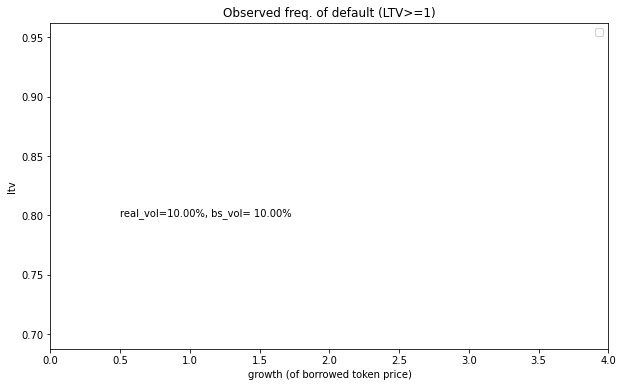

In [37]:

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from celluloid import Camera
import matplotlib.animation

camera = Camera(plt.figure())
_x, _y = 'growth', 'ltv'
i,j = 0,0
for real_vol in np.linspace(0.1, 0.5, 11):
    i += 1
    for bs_vol in np.linspace(0.1, 0.5, 11):
        j += 1    
        _df = df_plot[(df_plot.real_vol <real_vol+1e-4) &(df_plot.real_vol >real_vol-1e-4) \
                      & (df_plot.bs_vol< bs_vol+1e-4) & (df_plot.bs_vol>bs_vol-1e-4)]
        x, y, z = _df[_x], _df[_y], _df['default_risk']*100       
        sc = plt.scatter(x,y, s=z)
        plt.legend(*sc.legend_elements("sizes", num = 10))
        plt.xlabel('growth (of borrowed token price)')
        plt.ylabel('ltv')
        plt.title('Observed freq. of default (LTV>=1)')
        plt.xlim(0,4)
        plt.text(0.5, 0.8, "real_vol={:.2%}, bs_vol= {:.2%}".format(real_vol, bs_vol))
        if i%3 ==0 & j%3 ==0:
            camera.snap()
camera.snap()         
anim = camera.animate()
writergif = matplotlib.animation.PillowWriter(fps=3)
anim.save('default_simulation.gif', writer=writergif)
# numpoints = 10
# points = np.random.random((2, numpoints))
# colors = cm.rainbow(np.linspace(0, 1, numpoints))
# camera = Camera(plt.figure())
# for _ in range(100):
#     points += 0.1 * (np.random.random((2, numpoints)) - .5)
#     plt.scatter(*points, c=colors, s=100)
#     camera.snap()
